In [78]:
#importing libraries 
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
%matplotlib inline
from PIL import Image
import cv2
import os
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Dropout, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Concatenate, Add
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import datetime, os


In [5]:
#loading train.csv using pandas
df = pd.read_csv('/content/train.csv')

In [6]:
#printing the shape of dataframe & dataframe head
print('Shape of dataframe: ', df.shape)
df.head()

Shape of dataframe:  (7095, 3)


,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [7]:
#stripping ImageId strings
df['ImageId'] = df['ImageId'].apply(lambda x: x.strip())
#fetching details about ImageId column
df.ImageId.describe()

count              7095
unique             6666
top       ef24da2ba.jpg
freq                  3
Name: ImageId, dtype: object

- No null values in ImageId column since 'Count' & 'size'(of datframe) values are equal/same.
- Out of 7095 rows, 6666 unique image ids are found.
- Most repeated image('db4867ee8.jpg') was repeated '3' .

In [8]:
train_img_set = set(list(os.listdir('train_images')))
print('Total number of images in train_images folder: ', len(train_img_set))
defect_img_set = set(df['ImageId'].values)
print('Total number of images that are included in train.csv: ', len(defect_img_set))
if (defect_img_set.issubset(train_img_set)):
    print('All the ImageId that are mentioned in train.csv are present in train_images folder.')

Total number of images in train_images folder:  12568
Total number of images that are included in train.csv:  6666
All the ImageId that are mentioned in train.csv are present in train_images folder.


- Out of 12568 images, 6666 are defective.

Number of ImageIds that are not defective:  5902


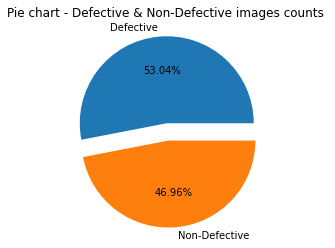

In [9]:
print('Number of ImageIds that are not defective: ', len(train_img_set) - len(defect_img_set))
non_defect_img_set = train_img_set - defect_img_set

#plotting pie-chart for their counts
plt.pie([len(defect_img_set), len(non_defect_img_set)], labels = ['Defective', 'Non-Defective'], explode = [0.1]*2, startangle = 0, autopct='%1.2f%%')
plt.title('Pie chart - Defective & Non-Defective images counts ')
plt.show()

In [10]:
df['ClassId'].astype('str').describe()

count     7095
unique       4
top          3
freq      5150
Name: ClassId, dtype: object

- No null values found in ClassId column(dataframe size & count are equal)
- 4 unique values in column ClassId
- most repeated ClassId is '3' with frequency; 5150

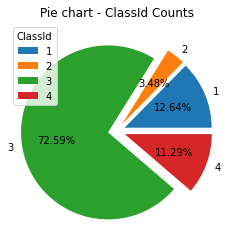

,ClassId,Count,count-percentage
0,1,897,12.642706
1,2,247,3.481325
2,3,5150,72.586328
3,4,801,11.289641


In [11]:
ClassId_cnt_df = pd.DataFrame(df['ClassId'].value_counts().sort_index()).rename(columns = {'ClassId':'Count'})
ClassId_cnt_df['count-percentage'] = ClassId_cnt_df*100/ClassId_cnt_df.sum()

plt.pie(ClassId_cnt_df['Count'], labels = ClassId_cnt_df['Count'].index, explode = [0.1]*4, startangle = 0, autopct='%1.2f%%')
plt.legend(title = "ClassId")
plt.title('Pie chart - ClassId Counts')
plt.show()

ClassId_cnt_df.reset_index().rename(columns = {'index':'ClassId'})

- These defective data-points are highly imbalanced.
- majority of the data-points(72.6%) are of ClassId - 3. 
- ClassId - 1 & 2 have almost equal share (12.6% & 11.3% respectively).
- Datapoints with ClassId - 2 has the lowest share among all.

In [12]:
#Number of labels for each image
#grouping dataframe by ImageIds & getting count of classes labeled for each image
nos_labels_per_img_df = df.groupby('ImageId')['ClassId'].count()#reset_index()#.rename(columns = {'ClassId':'Count'})
nos_labels_per_img_df.head(10)

ImageId
0002cc93b.jpg    1
0007a71bf.jpg    1
000a4bcdd.jpg    1
000f6bf48.jpg    1
0014fce06.jpg    1
0025bde0c.jpg    2
002af848d.jpg    1
002fc4e19.jpg    2
0030401a5.jpg    1
0046839bd.jpg    1
Name: ClassId, dtype: int64

In [13]:
data = nos_labels_per_img_df.value_counts().sort_index()
for index, value in data.items():
    print("Number of images with {} number of defect labels: {}".format(index, value))

Number of images with 1 number of defect labels: 6239
Number of images with 2 number of defect labels: 425
Number of images with 3 number of defect labels: 2


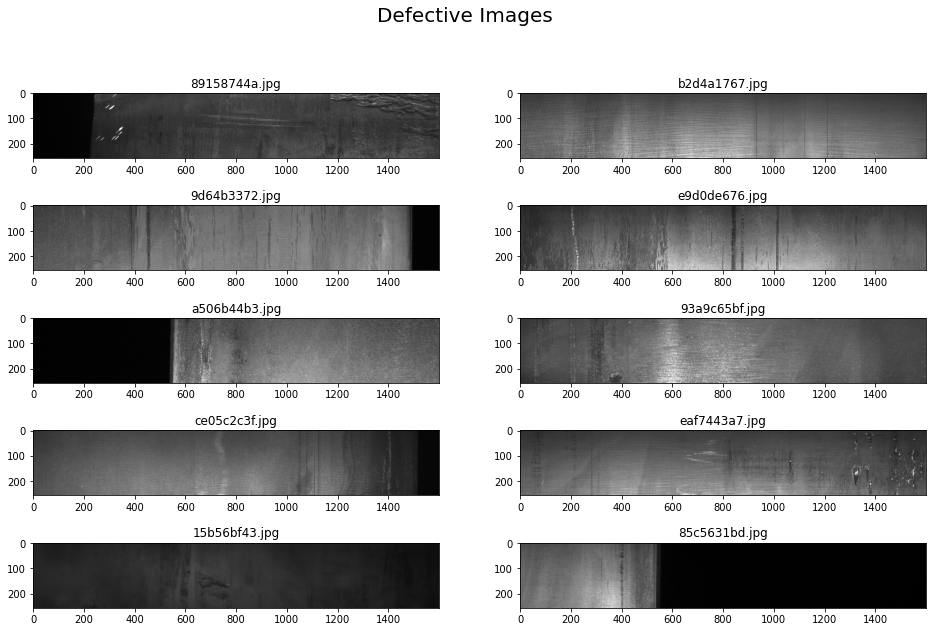

In [14]:
#displaying few images from defective image set
fig, axs = plt.subplots(5, 2, figsize=(16,10))
fig.suptitle('Defective Images', fontsize=20)
x,y = 0,0
for i, img_id in enumerate(random.sample(defect_img_set, 10)):
    img_obj = cv2.imread('train_images/'+ img_id)
    axs[i//2,i%2].imshow(img_obj)
    axs[i//2,i%2].set_title(img_id)
plt.show()

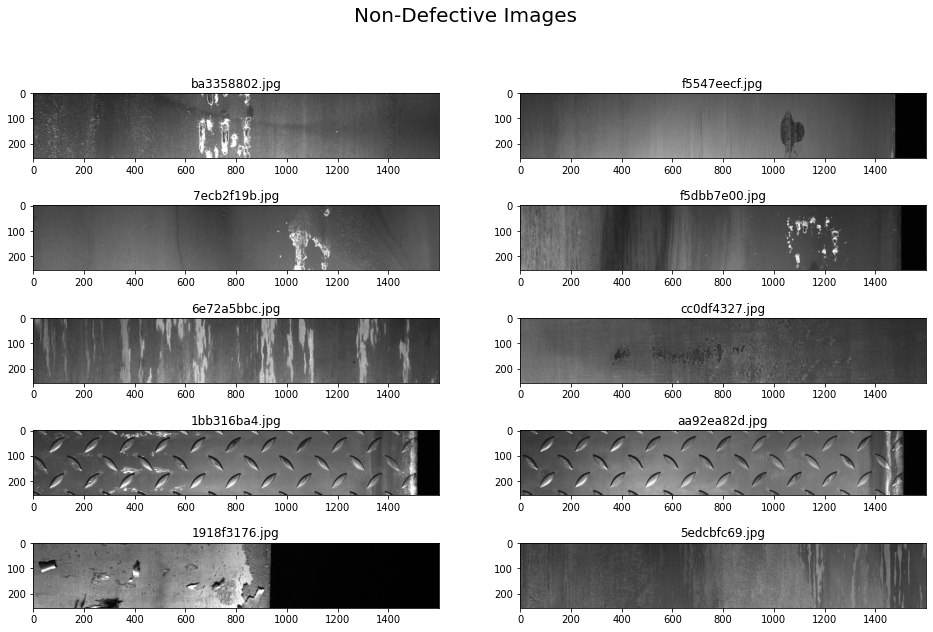

In [15]:
#displaying few images from non-defective image set
fig, axs = plt.subplots(5, 2, figsize=(16,10))
fig.suptitle('Non-Defective Images', fontsize=20)
x,y = 0,0
for i, img_id in enumerate(random.sample(non_defect_img_set, 10)):
    img_obj = cv2.imread('train_images/'+ img_id)
    axs[i//2,i%2].imshow(img_obj)
    axs[i//2,i%2].set_title(img_id)
plt.show()

- It looks like even some of the images from Non-defective set(ImgaeIds that are not in train.csv) are defective. May be these defect classes are not in [1, 2, 3, 4].

In [16]:
#checking if all the images in train_images folder are of same shape
img_shapes = set()
for img in list(os.listdir('train_images')):
    img_shapes.add(cv2.imread('train_images/'+img).shape)
img_shapes

{(256, 1600, 3)}

- Hence, all the images are of same shapes i.e., (256, 1600, 3)

In [17]:
#defining function for converting EncodedPixels(rle: run length encoding) to mask
def rle2mask(rle_string, img_shape=(256,1600)):
    '''
    input: EncodedPixels (run-length-encoded) string & image shape:-(width,height)
    output: mask in numpy.ndarray format with shape (256,1600)
    '''
    rle_array = np.array([int(s)for s in rle_string.split()])
    starts_array = rle_array[::2]-1
    lengths_array = rle_array[1::2]
    mask_array = np.zeros(img_shape[0]*img_shape[1],dtype=np.uint8)
    #print(starts_array,lengths_array)
    for i in range(len(starts_array)):
        mask_array[starts_array[i]:starts_array[i]+lengths_array[i]] = 1
    #order='F' because encoded pixels are numbered from top to bottom, then left to right
    return mask_array.reshape(img_shape, order = 'F')

#defining function for converting given mask to EncodedPixels(rle: run length encoding)
def mask2rle(mask_array):
    '''
    input: mask in numpy.ndarray format
    output: EncodedPixels (run-length-encoded) string
    '''
    mask_array = mask_array.T.flatten()
    mask_array = np.concatenate([[0], mask_array, [0]])
    rle_array = np.where(mask_array[1:]!=mask_array[:-1])[0]+1
    rle_array[1::2] -= rle_array[::2]
    rle_string = ' '.join(map(str,rle_array))
    return rle_string

In [18]:
#checking if rle2mask & mask2rle are working as required
mask2rle(rle2mask(df['EncodedPixels'].iloc[0])) == df['EncodedPixels'].iloc[0]

True

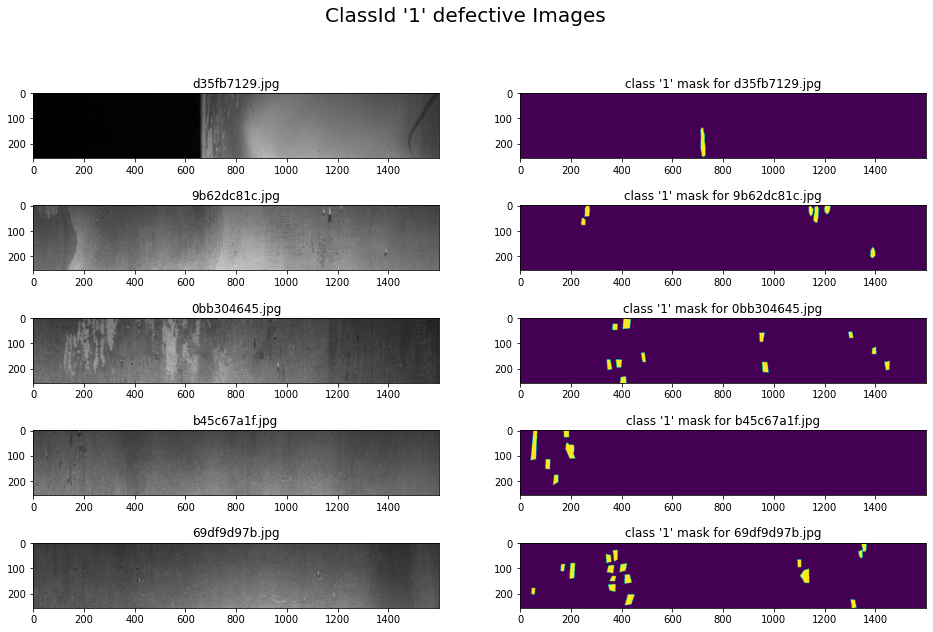

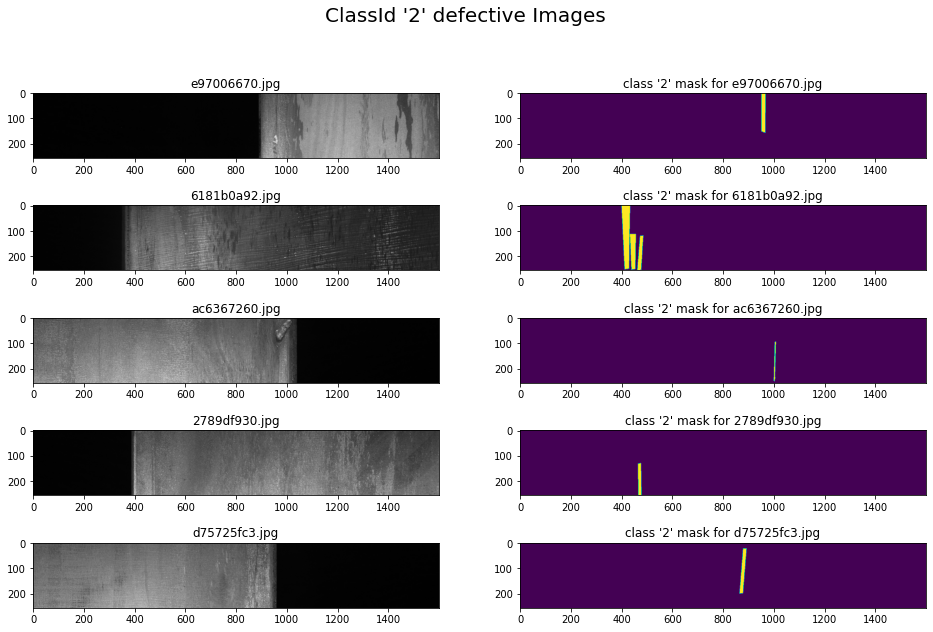

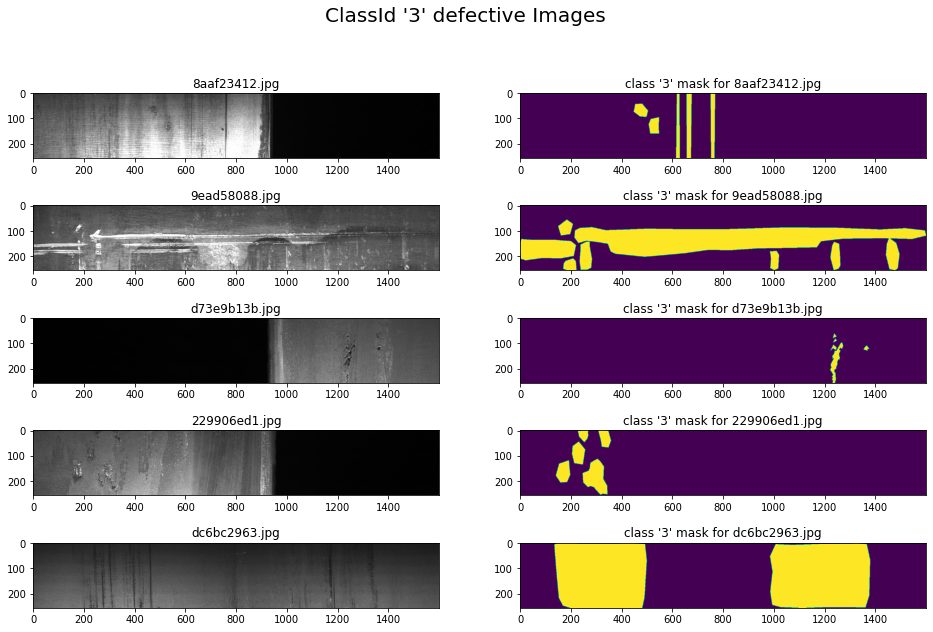

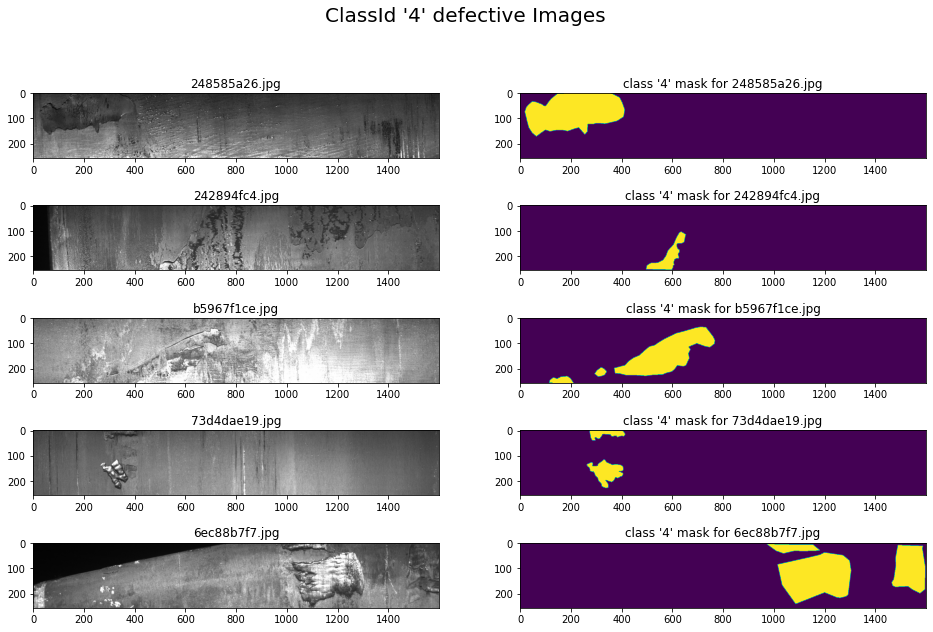

In [19]:
#displaying few defective images for each ClassIds 
for ClassId in [1,2,3,4]:
    class_df = df[df['ClassId'] == ClassId]
    fig, axs = plt.subplots(5, 2, figsize=(16,10))
    fig.suptitle("ClassId '{}' defective Images".format(ClassId), fontsize=20)
    x,y = 0,0
    for i, img_id in enumerate(random.sample(set(class_df['ImageId'].values), 5)):
        img_obj = cv2.imread('train_images/'+ img_id)
        axs[i,0].imshow(img_obj)
        axs[i,0].set_title(img_id)
        rle = class_df[class_df['ImageId'] == img_id]['EncodedPixels'].iloc[0]
        mask = rle2mask(rle)
        axs[i,1].imshow(mask)
        axs[i,1].set_title("class '{}' mask for ".format(ClassId) + img_id)
    plt.show()
    print('='*100)
  

- From the mask images, Class '2' defects have lesser defect areas when compared to other classes. And class '3' & '4' defects have more defect area when compared to others


In [20]:
#Creating dataframe for all the images in the train_images
train_images_list = list(os.listdir('train_images'))
length = len(train_images_list)
train_images_list = train_images_list*4
ClassIds = [1]*length + [2]*length + [3]*length + [4]*length

full_df = pd.DataFrame({'ImageId':train_images_list, 'ClassId':ClassIds})
full_df = full_df.sort_values(by = ['ImageId', 'ClassId']).reset_index(drop = True)
print(full_df.shape)
full_df.head(8)

(50272, 2)


,ImageId,ClassId
0,0002cc93b.jpg,1
1,0002cc93b.jpg,2
2,0002cc93b.jpg,3
3,0002cc93b.jpg,4
4,00031f466.jpg,1
5,00031f466.jpg,2
6,00031f466.jpg,3
7,00031f466.jpg,4


In [21]:
#merging both full_df & df
full_df = pd.merge(full_df, df, how ='outer', on= ['ImageId', 'ClassId'])
full_df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg,2,NaN
2,0002cc93b.jpg,3,NaN
3,0002cc93b.jpg,4,NaN
4,00031f466.jpg,1,NaN


In [22]:
full_df = pd.pivot_table(full_df, columns = ['ClassId'], index= ['ImageId'], aggfunc=np.sum).replace(0,'')
full_df = full_df.reset_index()
full_df.columns = ['ImageId', 'rle_1', 'rle_2', 'rle_3', 'rle_4']
full_df.to_csv("full_data.csv", index=False)
print('Shape of full_df: ', full_df.shape)
full_df.head()

Shape of full_df:  (12568, 5)


,ImageId,rle_1,rle_2,rle_3,rle_4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,
1,00031f466.jpg,,,,
2,000418bfc.jpg,,,,
3,000789191.jpg,,,,
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,


In [23]:
path='/content/'

In [24]:
full_data = pd.read_csv('/content/full_data.csv').fillna('')
full_data.head()

,ImageId,rle_1,rle_2,rle_3,rle_4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,
1,00031f466.jpg,,,,
2,000418bfc.jpg,,,,
3,000789191.jpg,,,,
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,


In [25]:
#splitting the data into train & cv
from sklearn.model_selection import train_test_split
train_data, validtn_data = train_test_split(full_data, test_size=0.15, random_state=42)
print(train_data.shape)
print(validtn_data.shape)

(10682, 5)
(1886, 5)


In [26]:
# Saving the train and validation data in csv files for future use
train_data.to_csv( "train_data.csv", index=False)
validtn_data.to_csv( "validtn_data.csv", index=False)

In [27]:
#loading train and validation data
train_data = pd.read_csv("train_data.csv").fillna('')
validtn_data = pd.read_csv("validtn_data.csv").fillna('')

### Data Generator Implementation

In [28]:
# Implementing custom data generator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size=32, num_classes=None, shuffle=True, preprocess=None):
        self.batch_size = batch_size
        self.df = dataframe
        self.indices = self.df.index.tolist()
        self.preprocess = preprocess
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.indices) // (self.batch_size)

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def __get_data(self, batch):
        train_datagen = ImageDataGenerator()
        param = {'flip_horizontal':True, 'samplewise_std_normalization' : True,
                 'width_shift_range':0.1, 'height_shift_range':0.1,}
        X = np.empty((self.batch_size,256,1600,3),dtype=np.float32) # image place-holders
        Y = np.empty((self.batch_size,256,1600,4),dtype=np.float32)# 4 masks place-holders
              
        for i, id in enumerate(batch):
          img = Image.open('/content/train_images/' + str(self.df['ImageId'].loc[id]))
          X[i,] = train_datagen.apply_transform(x = img, transform_parameters = param)#input image
          for j in range(4): #looping for each class
                mask = rle2mask(self.df['rle_'+str(j+1)].loc[id])
                Y[i,:,:,j] = train_datagen.apply_transform(x = mask, transform_parameters = param)#mask for each class
                
        # preprocess input
        if self.preprocess!=None: X = self.preprocess(X)

        return X, Y

###  Utility Functions

In [29]:
#defining function for converting EncodedPixels(rle: run length encoding) to mask
def rle2mask(rle_string, img_shape=(256,1600)):
    '''
    input: EncodedPixels (run-length-encoded) string & image shape:-(width,height)
    output: mask in numpy.ndarray format with shape (256,1600)
    '''
    rle_array = np.array([int(s)for s in rle_string.split()])
    starts_array = rle_array[::2]-1
    lengths_array = rle_array[1::2]
    mask_array = np.zeros(img_shape[0]*img_shape[1],dtype=np.uint8)
    #print(starts_array,lengths_array)
    for i in range(len(starts_array)):
        mask_array[starts_array[i]:starts_array[i]+lengths_array[i]] = 1
    #order='F' because encoded pixels are numbered from top to bottom, then left to right
    return mask_array.reshape(img_shape, order = 'F')

#defining function for converting given mask to EncodedPixels(rle: run length encoding)
def mask2rle(mask_array):
    '''
    input: mask in numpy.ndarray format
    output: EncodedPixels (run-length-encoded) string
    '''
    mask_array = mask_array.T.flatten()
    mask_array = np.concatenate([[0], mask_array, [0]])
    rle_array = np.where(mask_array[1:]!=mask_array[:-1])[0]+1
    rle_array[1::2] -= rle_array[::2]
    rle_string = ' '.join(map(str,rle_array))
    return rle_string

#defining function for calculation of metric dice coefficient
def dice_coefficient(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.math.reduce_sum(y_true_f * y_pred_f)
    smoothing_const = 1e-9
    return (2. * intersection + smoothing_const) / (tf.math.reduce_sum(y_true_f) + tf.math.reduce_sum(y_pred_f) + smoothing_const)

#defining function for calculation of dice coefficient
def dice_loss(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    return (1-dice_coefficient(y_true, y_pred))

#defining function for calculation of loss function: binary cross entropy + dice loss
def bce_dice_loss(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    return binary_crossentropy(y_true, y_pred) + (1-dice_coefficient(y_true, y_pred))

### model1:  Unet Architecture 

In [30]:
# defining Unet architecture

def conv2D_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True ):
    """function to pass Input_tensor through 2- Conv2D layers configured as per the input parameters"""
    # first Conv2D layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    # second Conv2D layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    return x


def Unet_Model(input_image, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Encoder (Contraction Path)
    E1 = conv2D_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(E1)
    p1 = Dropout(dropout)(p1)

    E2 = conv2D_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(E2)
    p2 = Dropout(dropout)(p2)

    E3 = conv2D_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(E3)
    p3 = Dropout(dropout)(p3)

    E4 = conv2D_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(E4)
    p4 = Dropout(dropout)(p4)

    E5 = conv2D_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Decoder (Expansive Path)
    D6 = Conv2DTranspose(n_filters * 8, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(E5)
    D6 = Concatenate()([D6, E4])
    D6 = Dropout(dropout)(D6)
    E6 = conv2D_block(D6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    D7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(E6)
    D7 = Concatenate()([D7, E3])
    D7 = Dropout(dropout)(D7)
    E7 = conv2D_block(D7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    D8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(E7)
    D8 = Concatenate()([D8, E2])
    D8 = Dropout(dropout)(D8)
    E8 = conv2D_block(D8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    D9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(E8)
    D9 = Concatenate()([D9, E1])
    D9 = Dropout(dropout)(D9)
    E9 = conv2D_block(D9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(4, (1, 1), activation='sigmoid')(E9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [31]:
#configuring input tensor for unet model
input_img = Input((256, 1600, 3), name='img')

model1 = Unet_Model(input_img, n_filters=8, dropout=0.2, batchnorm=True)
model1.compile(optimizer=Adam(), loss=bce_dice_loss, metrics=[dice_coefficient])
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 256, 1600,   0           []                               
                                3)]                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 1600, 8  224         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 256, 1600, 8  32         ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

### model2:  Linknet Architecture 

In [32]:
# defining LinkNet architecture
def conv2D_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True ):
    """function to pass Input_tensor through 2- Conv2D layers configured as per the input parameters"""
    # first Conv2D layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    # second Conv2D layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    return x

def Linknet_Model(input_image, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Encoder (Contraction Path)
    E1 = conv2D_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(E1)
    p1 = Dropout(dropout)(p1)

    E2 = conv2D_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(E2)
    p2 = Dropout(dropout)(p2)

    E3 = conv2D_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(E3)
    p3 = Dropout(dropout)(p3)

    E4 = conv2D_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(E4)
    p4 = Dropout(dropout)(p4)

    E5 = conv2D_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Decoder (Expansive Path)
    D6 = Conv2DTranspose(n_filters * 8, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(E5)
    D6 = Add()([D6, E4])
    D6 = Dropout(dropout)(D6)
    E6 = conv2D_block(D6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    D7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(E6)
    D7 = Add()([D7, E3])
    D7 = Dropout(dropout)(D7)
    E7 = conv2D_block(D7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    D8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(E7)
    D8 = Add()([D8, E2])
    D8 = Dropout(dropout)(D8)
    E8 = conv2D_block(D8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    D9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(E8)
    D9 = Add()([D9, E1])
    D9 = Dropout(dropout)(D9)
    E9 = conv2D_block(D9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(4, (1, 1), activation='sigmoid')(E9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [33]:
#configuring input tensor for linket model
input_img = Input((256, 1600, 3), name='img')

model2 = Linknet_Model(input_img, n_filters=8, dropout=0.2, batchnorm=True)
model2.compile(optimizer=Adam(), loss=bce_dice_loss, metrics=[dice_coefficient])
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 256, 1600,   0           []                               
                                3)]                                                               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 256, 1600, 8  224         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_19 (BatchN  (None, 256, 1600, 8  32         ['conv2d_20[0][0]']              
 ormalization)                  )                                                           

In [41]:
#loading train & validation data using DataGenerator class defined
train_batches = DataGenerator(train_data,shuffle=True)
validtn_batches = DataGenerator(validtn_data,shuffle=False)

## Training each model

### model1:unet

In [ ]:
#defining ModelCheckpoint to make a checkpoint when validation dice coefficient improves
checkpoints1 = ModelCheckpoint(path+'unet.h5', \
                              monitor='val_dice_coefficient', verbose=1, save_best_only=True, mode='max')

#adding ModelCheckpoint & TensorBoard to callback functions list
callbacks_list1 = [checkpoints1]

In [ ]:
history1 = model1.fit(train_batches,validation_data=validtn_batches, epochs = 15, callbacks=callbacks_list1)

Epoch 1/15
333/333 [==============================] - ETA: 0s - loss: 1.4287 - dice_coefficient: 0.0131
Epoch 1: val_dice_coefficient improved from -inf to 0.01581, saving model to /content/unet.h5
333/333 [==============================] - 382s 1s/step - loss: 1.4287 - dice_coefficient: 0.0131 - val_loss: 1.2207 - val_dice_coefficient: 0.0158
Epoch 2/15
333/333 [==============================] - ETA: 0s - loss: 1.1022 - dice_coefficient: 0.0319
Epoch 2: val_dice_coefficient improved from 0.01581 to 0.02674, saving model to /content/unet.h5
333/333 [==============================] - 369s 1s/step - loss: 1.1022 - dice_coefficient: 0.0319 - val_loss: 1.0478 - val_dice_coefficient: 0.0267
Epoch 3/15
333/333 [==============================] - ETA: 0s - loss: 0.8379 - dice_coefficient: 0.2128
Epoch 3: val_dice_coefficient improved from 0.02674 to 0.24020, saving model to /content/unet.h5
333/333 [==============================] - 369s 1s/step - loss: 0.8379 - dice_coefficient: 0.2128 - val_

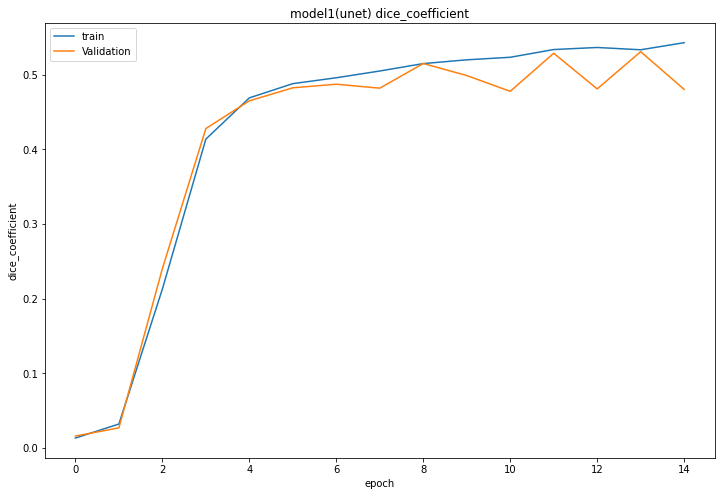

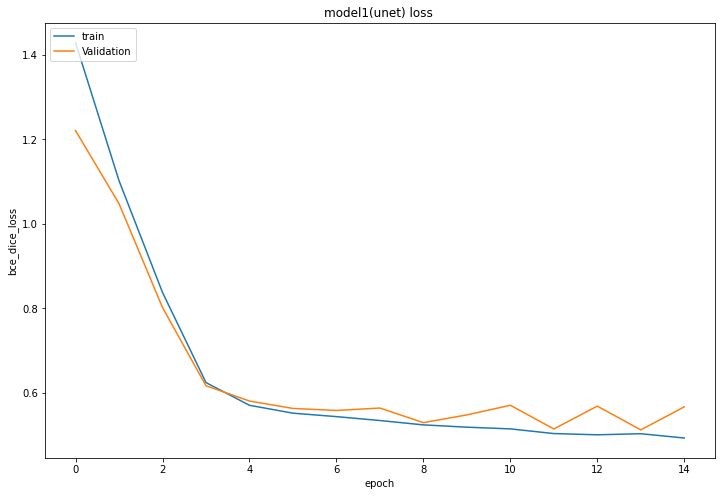

In [ ]:
# Visualizing history for dice_coefficient
plt.figure(figsize=(12, 8))
plt.plot(history1.history['dice_coefficient'])
plt.plot(history1.history['val_dice_coefficient'])
plt.title('model1(unet) dice_coefficient')
plt.ylabel('dice_coefficient')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()
# Visualizing history for loss
plt.figure(figsize=(12, 8))
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model1(unet) loss ')
plt.ylabel('bce_dice_loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

### model2:Linknet

In [74]:
#defining ModelCheckpoint to make a checkpoint when validation dice coefficient improves
checkpoints2 = ModelCheckpoint(path+'linknet.h5', \
                              monitor='val_dice_coefficient', verbose=1, save_best_only=True, mode='max')

#adding ModelCheckpoint & TensorBoard to callback functions list
callbacks_list2 = [checkpoints2]

In [75]:
history2 = model2.fit(train_batches,validation_data=validtn_batches, epochs = 15, callbacks=callbacks_list2)

Epoch 1/15
333/333 [==============================] - ETA: 0s - loss: 0.5171 - dice_coefficient: 0.5211
Epoch 1: val_dice_coefficient improved from -inf to 0.47590, saving model to /content/linknet.h5
333/333 [==============================] - 342s 1s/step - loss: 0.5171 - dice_coefficient: 0.5211 - val_loss: 0.5750 - val_dice_coefficient: 0.4759
Epoch 2/15
333/333 [==============================] - ETA: 0s - loss: 0.5097 - dice_coefficient: 0.5281
Epoch 2: val_dice_coefficient improved from 0.47590 to 0.47791, saving model to /content/linknet.h5
333/333 [==============================] - 325s 974ms/step - loss: 0.5097 - dice_coefficient: 0.5281 - val_loss: 0.5716 - val_dice_coefficient: 0.4779
Epoch 3/15
333/333 [==============================] - ETA: 0s - loss: 0.5042 - dice_coefficient: 0.5332
Epoch 3: val_dice_coefficient improved from 0.47791 to 0.48389, saving model to /content/linknet.h5
333/333 [==============================] - 325s 974ms/step - loss: 0.5042 - dice_coefficient

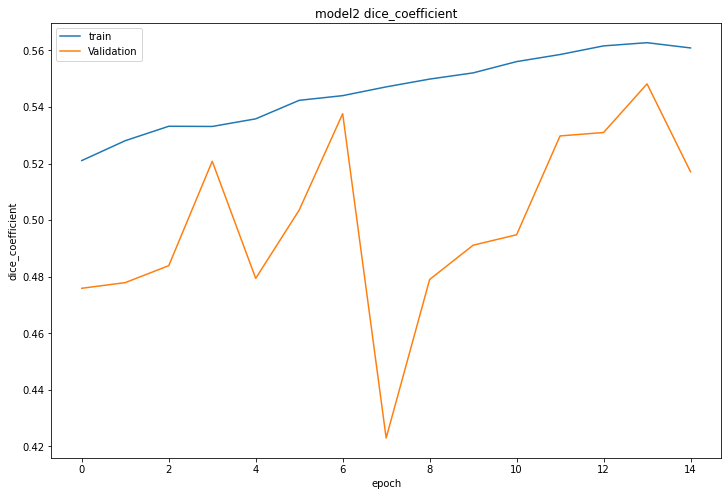

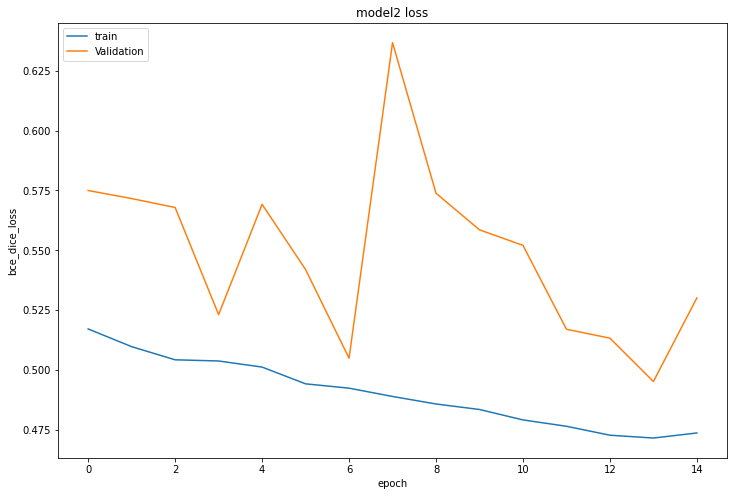

In [79]:
# Visualizing history for dice_coefficient
plt.figure(figsize=(12, 8))
plt.plot(history2.history['dice_coefficient'])
plt.plot(history2.history['val_dice_coefficient'])
plt.title('model2 dice_coefficient')
plt.ylabel('dice_coefficient')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()
# Visualizing history for loss
plt.figure(figsize=(12, 8))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model2 loss')
plt.ylabel('bce_dice_loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

### Visualizing Model Predictions

In [80]:

from keras.models import load_model

model1 = load_model('/content/unet (1).h5', custom_objects={'bce_dice_loss':                   
bce_dice_loss,'dice_coefficient':dice_coefficient})

model2 = load_model('/content/linknet.h5', custom_objects={'bce_dice_loss':                   
bce_dice_loss,'dice_coefficient':dice_coefficient})

In [81]:
#defining function to display GroundTruth & Predicted mask images for a given imageId
def visualize_model_prediction(img_id):
    fig, axs = plt.subplots(4, 4, figsize=(16,8))
    img_obj = cv2.imread('/content/train_images/'+ img_id)
    masks_actual = full_data[full_data['ImageId'] == img_id]
    x = np.empty((1,256,1600,3),dtype=np.float32) # image place-holders
    x[0,] = Image.open('/content/train_images/' + img_id)
    masks_predicted1 = model1.predict(x)
    masks_predicted2= model2.predict(x)

    for i in range(4):
        axs[i,0].imshow(img_obj)
        axs[i,0].set_title(img_id)
        axs[i,1].imshow(rle2mask(masks_actual['rle_'+str(i+1)].iloc[0]))
        axs[i,1].set_title("Actual mask for Class '{}'".format(i+1) )
        axs[i,2].imshow(masks_predicted1[0,:,:,i])
        axs[i,2].set_title("unet Predicted mask for Class '{}'".format(i+1))
        axs[i,3].imshow(masks_predicted2[0,:,:,i])
        axs[i,3].set_title("linket Predicted mask for Class '{}'".format(i+1))

    plt.show()

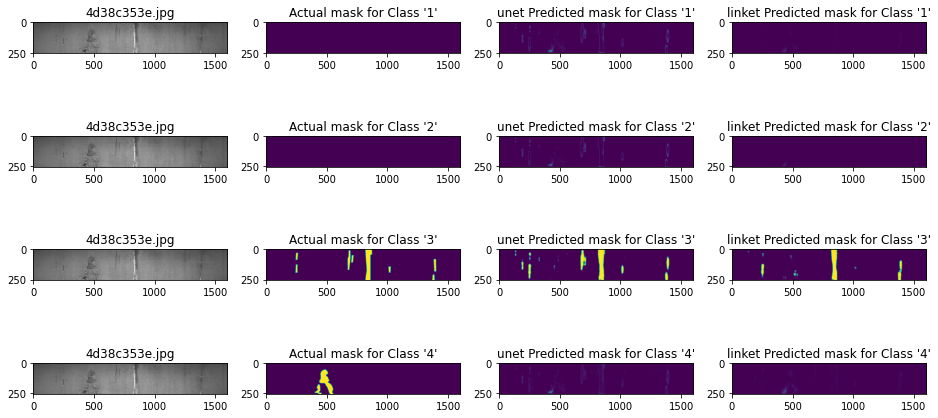

In [82]:
visualize_model_prediction('4d38c353e.jpg')

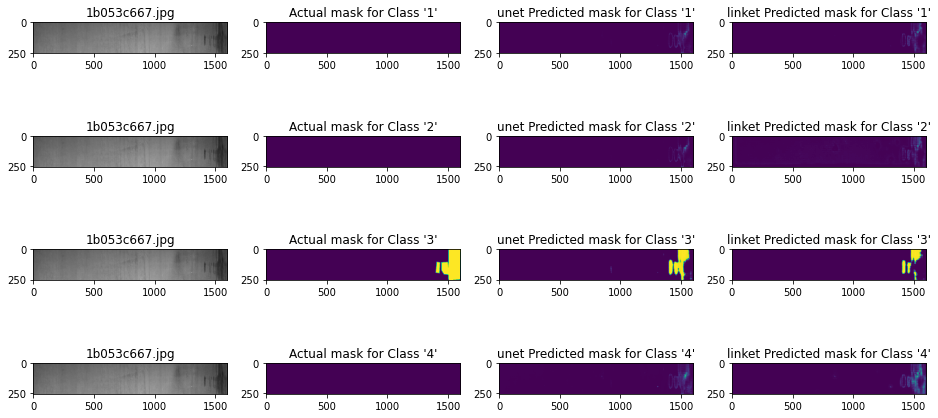

In [88]:
visualize_model_prediction('1b053c667.jpg')

## RESULTS:

In [72]:
from prettytable import PrettyTable 
  
myTable = PrettyTable([ "Model", "Validation Score", "competition submission Score"]) 

myTable.add_row(["UNet", "0.63119", "0.80213"]) 
myTable.add_row(["LinkNet", "0.63115", "0.79697"]) 
print(myTable)

+---------+------------------+------------------------------+
|  Model  | Validation Score | competition submission Score |
+---------+------------------+------------------------------+
|   UNet  |     0.63119      |           0.80213            |
| LinkNet |     0.63115      |           0.79697            |
+---------+------------------+------------------------------+


clearly Unet outperformes linknet both in validation score as well as submission score.